In [29]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, Dropout, Attention , Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = "/content/drive/MyDrive/Dataset.txt"

# Check if the data has already been loaded
if 'content' in locals() or 'content' in globals():
    print("Data is already loaded.")
else:
    # Load the data from the file
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            text = file.readlines()
    else:
        print("File does not exist.")


In [5]:
lines = [line.strip() for line in text]

In [6]:
print(len(lines))

24638


In [7]:
print(text[:50])

['Hi.\tمرحبًا.\n', 'Run!\tاركض!\n', 'Help!\tالنجدة!\n', 'Jump!\tاقفز!\n', 'Stop!\tقف!\n', 'Go on.\tداوم.\n', 'Go on.\tاستمر.\n', 'Hello!\tمرحباً.\n', 'Hurry!\tتعجّل!\n', 'Hurry!\tاستعجل!\n', 'I see.\tانا اري\n', 'I won!\tأنا فُزت!\n', 'Relax.\tاسترح.\n', 'Smile.\tابتسم.\n', 'Cheers!\tفي صحتك.\n', 'Got it?\tهل فهمت؟\n', 'He ran.\tركض.\n', 'I know.\tأعرف.\n', 'I know.\tأعلم ذلك.\n', 'I know.\tأنا أعلم\n', "I'm 19.\tأنا في 19\n", "I'm OK.\tأنا بخير.\n", 'Listen.\tاستمع\n', 'No way!\tغير معقول!\n', 'Really?\tحقاً؟\n', 'Thanks.\tشكرا.\n', 'Why me?\tلماذا أنا؟\n', 'Awesome!\tرائع!\n', 'Be cool.\tخذ راحتك.\n', 'Call me.\tهاتفني.\n', 'Call me.\tاتصل بي.\n', 'Come in.\tتفضل بالدخول.\n', 'Come in.\tتعال إلى الداخل\n', 'Come on!\tبالله عليك!\n', 'Come on!\tهيا\n', 'Come on!\tهيّا\n', 'Get out!\tاخرج من هنا!\n', 'Get out!\tأُخرج!\n', 'Get out.\tاخرج!\n', 'Go away.\tاتركني و شأني.\n', 'Go away.\tاذهب بعيداً.\n', 'Go away.\tارحل.\n', 'Goodbye!\tمع السلامة.\n', 'He came.\tلقد أتى.\n', 'He runs.\tهو ي

In [8]:
with open(file_path, 'r') as f:
    string = f.read()

with open('eng_arab.txt','w') as f:
    f.write(string)

In [9]:
data = pd.read_csv('eng_arab.txt',sep="\t",header=None)
data.columns=['English', "Arabic"]
data['English'] = data['English'].str.replace('<', '')
data['English'] = data['English'].str.replace('>', '')
data['Arabic'] = data['Arabic'].str.replace('>', '')
data['Arabic'] = data['Arabic'].str.replace('<', '')
data['English'] = "< "+data['English']+" >"
data['Arabic'] = "< "+data['Arabic']+" >"

In [10]:
# to remove the english and tashkeel from the arabic data

# Regular expression pattern to match English and tashkeel in Arabic text
english_pattern = r'[a-zA-Z]+'
tashkeel_pattern = r'[\u064B-\u0652]+'

# Function to remove English and tashkeel from a sentence
def remove_english_and_tashkeel(text):
    text = re.sub(english_pattern, '', text)  # Remove English
    text = re.sub(tashkeel_pattern, '', text)  # Remove Tashkeel
    return text


for i in range(len(data['Arabic'])):
    arabic_sentence = data['Arabic'][i]
    cleaned_arabic = remove_english_and_tashkeel(arabic_sentence)
    data['Arabic'][i] = cleaned_arabic

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24638 entries, 0 to 24637
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  24638 non-null  object
 1   Arabic   24638 non-null  object
dtypes: object(2)
memory usage: 385.1+ KB


In [12]:
num_samples = 10_000

data = data.head(num_samples)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  10000 non-null  object
 1   Arabic   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [14]:
input_texts = data['English'].to_list()
output_texts = data['Arabic'].to_list()

In [15]:
input_characters = set()

for sentence in input_texts:
  for char in sentence:
    input_characters.add(char)

In [16]:
output_characters = set()

for sentence in output_texts:
  for char in sentence:
    output_characters.add(char)

In [17]:
# unique source lang (english) characters, unique target lang (arabic) characters
len(input_characters), len(output_characters)

(75, 78)

In [18]:
input_characters = sorted(list(input_characters))
output_characters = sorted(list(output_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(output_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in output_texts])

num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length

(75, 78, 48, 69)

In [19]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
output_token_index = dict([(char, i) for i, char in enumerate(output_characters)])

In [20]:
# Input Sequences (English): Padded to a maximum length of 48 characters with a vocabulary of 75 different characters (10000, 48, 75).
# Output Sequences (Arabic): Padded to a maximum length of 69 characters with a vocabulary of 107 different characters (10000, 69, 78).

encoder_input_data = np.zeros((num_samples, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((num_samples, max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_output_data = np.zeros((num_samples, max_decoder_seq_length, num_decoder_tokens), dtype='float32')

encoder_input_data.shape, decoder_input_data.shape

((10000, 48, 75), (10000, 69, 78))

In [21]:
for i, (input_text, target_text) in enumerate(zip(input_texts, output_texts)):
  for t, char in enumerate (input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0

  encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.0

  for t, char in enumerate(target_text):
    decoder_input_data[i, t, output_token_index[char]] = 1.0
    if t > 0:
      decoder_output_data[i, t - 1, output_token_index[char]] = 1.0

  decoder_input_data[i, t + 1:, output_token_index[' ']] = 1.0
  decoder_output_data[i, t:, output_token_index[' ']] = 1.0

In [22]:
encoder_input_data.shape

(10000, 48, 75)

In [23]:
encoder_input_data[0].shape

(48, 75)

In [24]:
encoder_input_data[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [25]:
encoder_input_data[0][2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [26]:
# Define LSTM units
lstm_dim = 128

#using bidirectional lstm
# Encoder Definition
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = Bidirectional(LSTM(lstm_dim, return_sequences=False, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)

state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

encoder_states = [state_h, state_c]

In [27]:
# Decoder Definition
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(2*lstm_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

In [30]:
# Attention Layer
attention = Attention()([decoder_outputs, encoder_outputs])
context = Concatenate()([decoder_outputs, attention])

In [31]:
# Dense Layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(context)

In [32]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [33]:
# Compile the model with a different optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Adjust batch size and epochs
batch_size = 64
epochs = 30

history = model.fit(
    x=[encoder_input_data, decoder_input_data],
    y=decoder_output_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)]
)

Epoch 1/30
125/125 [==============================] - 81s 603ms/step - loss: 1.1214 - accuracy: 0.7556 - val_loss: 1.4462 - val_accuracy: 0.6385
Epoch 2/30
125/125 [==============================] - 74s 591ms/step - loss: 0.8710 - accuracy: 0.7677 - val_loss: 1.3241 - val_accuracy: 0.6475
Epoch 3/30
125/125 [==============================] - 74s 594ms/step - loss: 0.7887 - accuracy: 0.7881 - val_loss: 1.2119 - val_accuracy: 0.6771
Epoch 4/30
125/125 [==============================] - 71s 573ms/step - loss: 0.7809 - accuracy: 0.7980 - val_loss: 1.3092 - val_accuracy: 0.6432
Epoch 5/30
125/125 [==============================] - 74s 596ms/step - loss: 0.7283 - accuracy: 0.8056 - val_loss: 1.1185 - val_accuracy: 0.7003
Epoch 6/30
125/125 [==============================] - 74s 596ms/step - loss: 0.6835 - accuracy: 0.8152 - val_loss: 1.0849 - val_accuracy: 0.7067
Epoch 7/30
125/125 [==============================] - 71s 573ms/step - loss: 0.6639 - accuracy: 0.8191 - val_loss: 1.0609 - val_ac

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

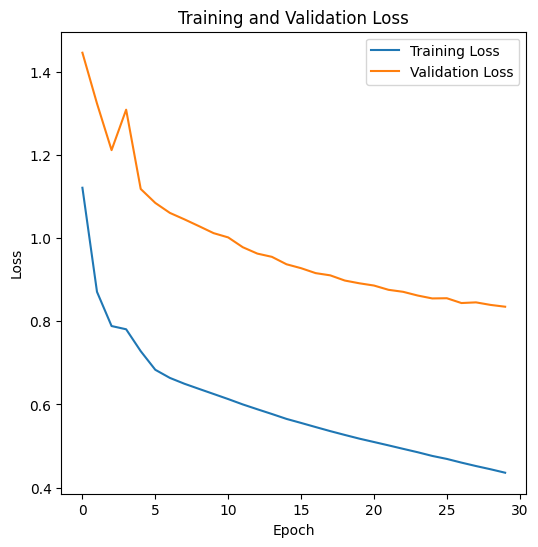

In [36]:
plt.figure(figsize=(6, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()